## Модуль Б.  Разведочный анализ данных

#### Импортирование библиотек

In [94]:
import pandas as pd
import io
import glob
import re
import nltk
import matplotlib.pyplot as plt
import pymorphy2
import fitz
import string
import numpy as np
import re
import pyLDAvis
import pyLDAvis.gensim
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.tokenize import word_tokenize
from tqdm.auto import tqdm, trange
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn
from __future__ import division
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

### 1.2 Формирование структуры набора данных

### Описание структуры данных

__TitleCompany__ - Название компании

__Description__ - Описание компании

__Reiting__ - Рейтинг компании

__Categories__ - Категории компании


__TitleCompany__ - Название компании

__Description__ - Описание компании

__Reiting__ - Рейтинг компании

__Categories__ - Категории компании

__TextPostLemat__ - обработанный, лематизированный текст 

__TextPostToken__ - обработанный, токенизированный и лематизированный текст (лематизирован другим способом нежели TextPostLemat)

__bigram__ - биграммы обработанного и лематизированного текста

__trigram__ - триграммы обработанного и лематизированного текста

__keyword__ - ключевые слова обработанного и лематизированного текста

__clustersAgglomerative__ - кластеры, образованные моделью Agglomerative

__clustersKmeans__ - кластеры, образованные моделью Kmeans

__clustersSpectral__ - кластеры, образованные моделью Spectral

#### Установка библиотек

In [2]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


### 2.1 Поиск ключевых слов/n-грамм. Векторизация текстов

In [3]:
dfHabr1 = pd.read_csv('Report1.csv')

In [4]:
mystem = Mystem() 
# добавление стопслов
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'быть', 'r', 'n', 'а', 'мы', 'с', 'для', 'ещё', 'его', 'также', 'к', 'тем', 'кто', 'чтобы', 'но', 'они', 'будут', 'так', 'где', 'один', 'он ', 'и', 'на', 'но', 'или', 'либо', 'это', 'мб', 'далее', 'дв', 'свой', 'ваш','всё', 'очень', 'её', 'ещё', 'вообще', 'наш', 'который'])

Из-за проблем с чтением нужно заново токенизировать текст, именно поэтому заново прописываю метод токенизации на лемматизированном тексте

In [5]:
def tokenize(text):
    t = word_tokenize(text)
    return [token for token in t if token not in russian_stopwords]

In [6]:
prep_text1 = [tokenize(text.lower()) for text in tqdm(dfHabr1['TextPostLemat']) if text not in russian_stopwords]

  0%|          | 0/91 [00:00<?, ?it/s]

In [7]:
dfHabr1['TextPostToken'] = prep_text1

In [8]:
dfHabr1['bigram'] = ''
dfHabr1['trigram'] = ''
dfHabr1['keyword'] = ''

In [9]:
# использование цикла с записью биграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['bigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 2))
# использование цикла с записью триграмм в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    dfHabr1['trigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 3))
# использование цикла с записью ключевых слов в датафрейм
for i in tqdm(range(len(dfHabr1['TextPostToken']))):
    freq_dist = nltk.FreqDist(dfHabr1['TextPostToken'][i])
    top_words = [word for word, count in freq_dist.most_common(10)]
    dfHabr1['keyword'][i] = ', '.join(top_words)

  0%|          | 0/91 [00:00<?, ?it/s]

C:\Users\essww\AppData\Local\Temp\ipykernel_15520\4148636806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHabr1['bigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 2))


  0%|          | 0/91 [00:00<?, ?it/s]

C:\Users\essww\AppData\Local\Temp\ipykernel_15520\4148636806.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHabr1['trigram'][i] = list(nltk.ngrams(dfHabr1['TextPostToken'][i], 3))


  0%|          | 0/91 [00:00<?, ?it/s]

C:\Users\essww\AppData\Local\Temp\ipykernel_15520\4148636806.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfHabr1['keyword'][i] = ', '.join(top_words)


In [10]:
dfHabr1.head()

,TitleCompany,Description,Reiting,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword
0,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",общий обзор новый алгоритм стеганография позво...,"[общий, обзор, новый, алгоритм, стеганография,...","[(общий, обзор), (обзор, новый), (новый, алгор...","[(общий, обзор, новый), (обзор, новый, алгорит...","алгоритм, информация, стеганография, контент, ..."
1,Timeweb Cloud,Облачная платформа для разработчиков и бизнеса,1542.55,"DIY или Сделай сам, История IT",студенческий год родитель союз студент часто п...,"[студенческий, год, родитель, союз, студент, ч...","[(студенческий, год), (год, родитель), (родите...","[(студенческий, год, родитель), (год, родитель...","ребенок, геркон, игрушка, мочь, простой, конта..."
2,Selectel,IT-инфраструктура для бизнеса,1935.27,"IT-компании, Производство и разработка электро...",явление называть именно обвал дело продажа жес...,"[явление, называть, именно, обвал, дело, прода...","[(явление, называть), (называть, именно), (име...","[(явление, называть, именно), (называть, именн...","млн, продажа, год, квартал, пк, рынок, динамик..."
3,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",закон физика говорить обо весь возможный явлен...,"[закон, физика, говорить, обо, весь, возможный...","[(закон, физика), (физика, говорить), (говорит...","[(закон, физика, говорить), (физика, говорить,...","дыра, чрной, событие, вселенная, горизонт, мат..."
4,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",существовать нарисовать вид анимешной девушка ...,"[существовать, нарисовать, вид, анимешной, дев...","[(существовать, нарисовать), (нарисовать, вид)...","[(существовать, нарисовать, вид), (нарисовать,...","человек, год, вид, становиться, хуманизация, б..."


In [11]:
def preprocess_text(data, stopwords=russian_stopwords):
    text = re.sub('ё','е', data.lower())
    text = text.strip()
    text = [w for w in text.split() if w not in stopwords] 
    text = [w for w in text if len(w) >=3]
    return ' '.join(text)

In [12]:
def transform_data(data: pd.Series) -> list:
    result = [preprocess_text(data=i) for i in data]
    return result

In [13]:
text = dfHabr1['TextPostLemat']

In [14]:
%%time
dfHabr2 = transform_data(text)

CPU times: total: 78.1 ms
Wall time: 130 ms


In [15]:
len(dfHabr2)

91

In [16]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=1)
count_matrix = vectorizer.fit_transform(dfHabr2)

In [17]:
count_matrix.toarray()[:2,:200]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 

In [18]:
count_matrix.shape

(91, 161652)

In [19]:
vectorizer.get_feature_names_out()[:50]

array(['ааа', 'ааа класс', 'ааа класс требовать', 'ааа проект',
       'ааа проект современность', 'аббревиатура',
       'аббревиатура название', 'аббревиатура название большинство',
       'аббревиатура обозначать', 'аббревиатура обозначать сторона',
       'аббревиатура расшифровываться',
       'аббревиатура расшифровываться запрос', 'абитуриент',
       'абитуриент вопрос', 'абитуриент вопрос прежде', 'абразив',
       'абразив кварц', 'абразив кварц угольный', 'абрам',
       'абрам совместный', 'абрам совместный работа', 'абрам старший',
       'абрам старший директор', 'абсолютно', 'абсолютно важный',
       'абсолютно важный игра', 'абсолютно любой',
       'абсолютно любой локация', 'абсолютно непонятный',
       'абсолютно непонятный вещь', 'абсолютно никуда',
       'абсолютно никуда полететь', 'абсолютно новый',
       'абсолютно новый технология', 'абсолютно нормальный',
       'абсолютно нормальный браузерный', 'абсолютно разный',
       'абсолютно разный неявный', 'абсо

In [20]:
len(vectorizer.get_feature_names_out())

161652

### 2.3 Кластеризация

In [21]:
# Выбор и применение алгоритма кластеризации
agg = AgglomerativeClustering(n_clusters=15).fit(count_matrix.toarray())

In [22]:
# Получение меток кластеров
labelsAgglomerative = agg.labels_
clusters1 = agg.labels_.tolist()

In [23]:
dfHabr1['clustersAgglomerative'] = clusters1

In [24]:
# Метод к-средних - KMeans
km = KMeans(n_clusters=15).fit(count_matrix.toarray())

C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [25]:
labelsKmeans = km.labels_
clusters2 = km.labels_.tolist()

In [26]:
dfHabr1['clustersKmeans'] = clusters2

In [27]:
# Создание модели DBSCAN
spectral = SpectralClustering(n_clusters=15).fit(count_matrix.toarray())

C:\Users\essww\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\essww\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [28]:
labelsSpectral = spectral.labels_
clusters3 = spectral.labels_.tolist()

In [29]:
dfHabr1['clustersSpectral'] = clusters3

In [30]:
print(labelsSpectral)

[ 1  8  1  1  2  1  1 12  3  2  1  1  1  1  1 12  2 12  3  3  1  3  1  1
  2  1  9  1  1  2  3  8  1  9  1  1 12  1  1  1  1  1 13  1  1 12  8  1
  1  1  1  1  1  7  2 11  1 12  9  3  1  4  5 12  1 12 14  8  3  3 12 12
  0  1  9  1  6  1  1  3 10  1 12  2  2  1  1 12 10  3  3]


In [31]:
print(labelsKmeans)

[ 4  4  4  4  4  4  4 12  7  4  4  4  4  4  0  4  4 11  4  4  4  4  4  4
  4 13  4  4  4  4  4  4  4  4  4  4  2  4  4  4  4  4  4  4  6  4  4  4
  4  4  1  4  4  4  4  4  4  4 10 14  4  4  4  4  9  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  5  4  4  4  8  4  4  4  3  4  4  4]


In [32]:
print(labelsAgglomerative)

[ 4  4  4  7  4  4  4  0 11  4  4  4  4  4  9  4 12  2  4  4  4  0  4  4
  0 13 10  0  0  4  4  4  4  4  4  4  8  4  4  4  4  1  4  4  0  4  4  0
  0  4  0  4  0  4  4  0  0  4 14  0  4  4  4  4  5  4  4  0  2  4  4  4
  4  4  4  4  4  4  0  6  1  1  4  1  4  4  4  3  4  4  4]


In [33]:
dfHabr1.head()

,TitleCompany,Description,Reiting,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword,clustersAgglomerative,clustersKmeans,clustersSpectral
0,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",общий обзор новый алгоритм стеганография позво...,"[общий, обзор, новый, алгоритм, стеганография,...","[(общий, обзор), (обзор, новый), (новый, алгор...","[(общий, обзор, новый), (обзор, новый, алгорит...","алгоритм, информация, стеганография, контент, ...",4,4,1
1,Timeweb Cloud,Облачная платформа для разработчиков и бизнеса,1542.55,"DIY или Сделай сам, История IT",студенческий год родитель союз студент часто п...,"[студенческий, год, родитель, союз, студент, ч...","[(студенческий, год), (год, родитель), (родите...","[(студенческий, год, родитель), (год, родитель...","ребенок, геркон, игрушка, мочь, простой, конта...",4,4,8
2,Selectel,IT-инфраструктура для бизнеса,1935.27,"IT-компании, Производство и разработка электро...",явление называть именно обвал дело продажа жес...,"[явление, называть, именно, обвал, дело, прода...","[(явление, называть), (называть, именно), (име...","[(явление, называть, именно), (называть, именн...","млн, продажа, год, квартал, пк, рынок, динамик...",4,4,1
3,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",закон физика говорить обо весь возможный явлен...,"[закон, физика, говорить, обо, весь, возможный...","[(закон, физика), (физика, говорить), (говорит...","[(закон, физика, говорить), (физика, говорить,...","дыра, чрной, событие, вселенная, горизонт, мат...",7,4,1
4,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",существовать нарисовать вид анимешной девушка ...,"[существовать, нарисовать, вид, анимешной, дев...","[(существовать, нарисовать), (нарисовать, вид)...","[(существовать, нарисовать, вид), (нарисовать,...","человек, год, вид, становиться, хуманизация, б...",4,4,2


In [35]:
topic = ['RUVDS.com', 'Selectel', 'Timeweb Cloud', 'OTUS', 'Яндекс', 'Open Data Science', 'ГК ЛАНИТ', 'VK', 'getmatch', 'Wiren Board', 'FirstVDS', 'Конференции Олега Бунина (Онтико)', 'AGIMA', 'Альфа-Банк', 'Postgres Professional', 'Ozon Tech', 'TINKOFF', 'Хабр Карьера', 'JUG Ru Group', 'Southbridge']

In [36]:
clust_res = pd.DataFrame(columns=['topic', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14'])
i = 0
topics = topic
for topic in topics:
    cnt = []
    for cluster in range(15):
        cnt.append(len(dfHabr1[dfHabr1.TitleCompany.eq(topic) &  dfHabr1.clustersAgglomerative.eq(cluster) ]))
    clust_res.loc[i] = [topic] + cnt
    i += 1
clust_res

,topic,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14
0,RUVDS.com,2,2,0,0,14,1,0,1,0,0,1,0,0,0,0
1,Selectel,1,0,0,0,8,0,0,0,0,0,0,0,0,0,0
2,Timeweb Cloud,2,0,0,0,6,0,1,0,0,0,0,0,0,0,0
3,OTUS,4,0,1,1,13,0,0,0,0,0,0,0,0,0,0
4,Яндекс,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Open Data Science,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,ГК ЛАНИТ,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,VK,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,getmatch,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9,Wiren Board,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


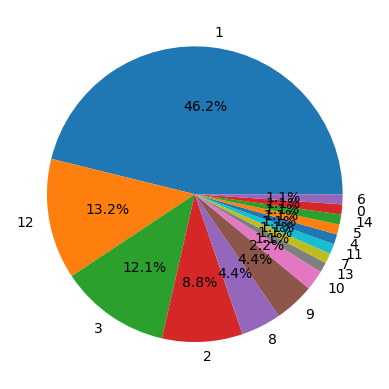

In [37]:
cluster_counts = dfHabr1['clustersSpectral'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

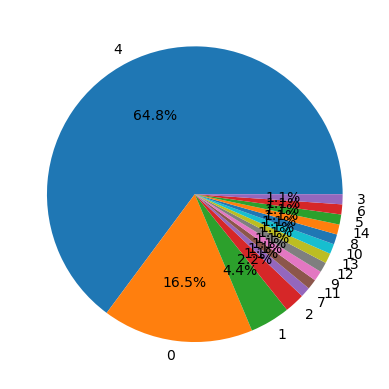

In [38]:
cluster_counts = dfHabr1['clustersAgglomerative'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

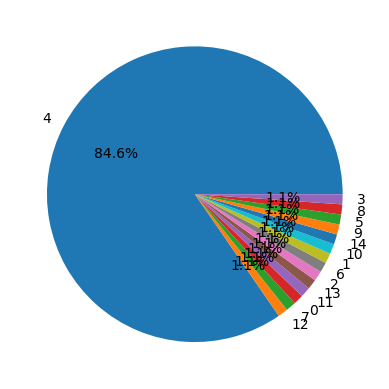

In [39]:
cluster_counts = dfHabr1['clustersKmeans'].value_counts()
plt.pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%')
plt.show()

In [40]:
prize = ['Государство и Общество','СМИ и массовые коммуникации','Образование и Кадры', 'Экономика и Бизнес', 'Путешествия по РФ', 'Наука, технологии и инновации', 'Здоровье и Отдых', 'Культурные проекты в сети', 'Народов много - Родина одна', 'Туризм и индустрия гостеприимства', 'Подкасты и цифровой контент']

In [41]:
a = (dfHabr1['clustersKmeans'] - dfHabr1['clustersKmeans'].mean()) / dfHabr1['clustersKmeans'].std()
a1 = (dfHabr1['clustersAgglomerative'] - dfHabr1['clustersAgglomerative'].mean()) / dfHabr1['clustersAgglomerative'].std()
a2 = (dfHabr1['clustersSpectral'] - dfHabr1['clustersSpectral'].mean()) / dfHabr1['clustersSpectral'].std()

In [42]:
data_norm_kmeans = a.values.reshape(-1, 1)
data_norm_agg = a1.values.reshape(-1, 1)
data_norm_spec = a2.values.reshape(-1, 1)

In [43]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_kmeans, km.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 0.8461538461538461


In [44]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_agg, agg.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 0.8791208791208791


In [45]:
# оценка качества кластеризации с помощью индекса силуэта
silhouette_avg = silhouette_score(data_norm_spec, spectral.labels_)
print("Silhouette  score:", silhouette_avg)

Silhouette  score: 0.9120879120879121


### 2.2 Тематическое моделирование

In [46]:
# создание модели LDA
lda_model = LatentDirichletAllocation(n_components=15, random_state=0)
lda_model.fit(count_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(lda_model.components_):
    print(f"Topic {i}: {', '.join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: пакет, функция, субд, команда, мочь, переменный, схема, новый, информация, весь
Topic 1: система, операционный, мочь, операционный система, сша, программа, данные, компьютер, устройство, каждый
Topic 2: файл, частота, пакет, устройство, сообщение, проект, точка, работа, работать, шрифт
Topic 3: мочь, команда, ошибка, сигнал, статья, год, растение, сумма, балл, схема
Topic 4: сеть, доступность, мочь, доступность сеть, мониторинг, модель, время, изображение, данные, работа
Topic 5: год, весь, игра, мочь, компания, вакансия, сертификат, работа, первый, приложение
Topic 6: имя, код, пространство, кластер, пространство имя, использовать, мочь, инфраструктура, функция, переменный
Topic 7: файл, устройство, интерфейс, использовать, мочь, конфигурационный, конфигурационный файл, настройка, сетевой, работа
Topic 8: тест, дыра, плата, чрной, чрной дыра, мочь, кейс, тест кейс, весь, время
Topic 9: метрика, данные, игра, клиент, мочь, сервер, приложение, время, количество, файл
Topic 10: 

In [47]:
len(lda_model.components_)

15

In [48]:
lda_model.components_

array([[0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 1.06666667,
        1.06666667],
       [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 0.06666667,
        0.06666667],
       [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 0.06666667,
        0.06666667],
       ...,
       [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 0.06666667,
        0.06666667],
       [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 0.06666667,
        0.06666667],
       [0.06666667, 0.06666667, 0.06666667, ..., 0.06666667, 0.06666667,
        0.06666667]])

In [49]:
# создание матрицы документ-термин
tfidf_vectorizer = TfidfVectorizer(stop_words=russian_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(dfHabr2)

In [50]:
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

In [51]:
tfidf_matrix.shape

(91, 10421)

In [52]:
# создание модели NMF
nmf_model = NMF(n_components=15, random_state=0)
nmf_model.fit(tfidf_matrix)

# вывод топ слов для каждой темы
for i, topic in enumerate(nmf_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: значение, функция, запрос, инстанс, код, состояние, мочь, парсер, счетчик, использовать
Topic 1: игра, игровой, игрок, персонаж, играть, студия, индустрия, мир, механика, геймификация
Topic 2: порт, озу, плата, процессор, слот, система, разъем, чип, ядро, оснащать
Topic 3: метрика, мониторинг, система, сбор, приложение, запрос, данные, собирать, логирование, квантиль
Topic 4: класс, код, поле, аннотация, файл, объект, десериализация, структура, константа, память
Topic 5: файл, кластер, сообщение, настройка, конфигурационный, сертификат, команда, ошибка, приложение, журнал
Topic 6: плата, сигнал, устройство, схема, питание, педаль, кабель, триггер, ток, преобразователь
Topic 7: тест, кейс, запрос, тесто, регрессионный, тестирование, спринт, тестировщик, тело, сервер
Topic 8: год, видео, человек, грейс, весь, индустрия, технология, становиться, проект, хоппер
Topic 9: анимация, элемент, реактивный, событие, стрим, метод, анимировать, компонент, оператор, изображение
Topic 10: ва

In [53]:
len(nmf_model.components_)

15

In [54]:
nmf_model.components_

array([[0.        , 0.00331242, 0.        , ..., 0.02849525, 0.0029467 ,
        0.        ],
       [0.01318924, 0.0001729 , 0.        , ..., 0.        , 0.01162124,
        0.02756057],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00060836, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00170797, 0.        , ..., 0.        , 0.        ,
        0.00072202]])

In [55]:
# создание модели LSA
lsa_model = TruncatedSVD(n_components=15, random_state=0)
lsa_model.fit(tfidf_matrix)
# вывод топ слов для каждой темы
for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: мочь, файл, система, данные, приложение, метрика, код, игра, устройство, использовать
Topic 1: игра, год, игровой, индустрия, игрок, человек, играть, персонаж, студия, мир
Topic 2: плата, порт, озу, система, слот, устройство, процессор, разъем, чип, ядро
Topic 3: метрика, мониторинг, сбор, система, запрос, приложение, данные, доступность, логирование, квантиль
Topic 4: игра, файл, озу, метрика, порт, класс, система, плата, слот, процессор
Topic 5: сервер, файл, сеть, устройство, клиент, коммутатор, игра, кластер, конфигурационный, сетевой
Topic 6: коммутатор, пакет, сигнал, схема, запрос, сервер, устройство, сеть, инсталляция, тест
Topic 7: тест, запрос, сервер, кейс, процессор, приложение, озу, тесто, порт, регрессионный
Topic 8: тест, файл, пакет, метрика, шрифт, проект, вакансия, команда, кейс, приложение
Topic 9: диск, устройство, анимация, файловый, кеш, приложение, операционный, система, кэширование, реактивный
Topic 10: вакансия, кандидат, значение, плата, анимация, мар

In [56]:
len(lsa_model.components_)

15

In [57]:
lsa_model.components_

array([[ 2.06477017e-03,  3.99719079e-03,  6.78133197e-04, ...,
         2.10043035e-03,  2.69073428e-03,  3.82109314e-03],
       [ 8.80286594e-03, -2.33461074e-03,  9.57661892e-04, ...,
        -2.40489331e-03,  6.91732884e-03,  1.64099153e-02],
       [-3.58680425e-03, -5.91570885e-05,  6.98839123e-05, ...,
        -2.56943721e-03, -2.81409031e-03, -6.89634384e-03],
       ...,
       [-1.08410276e-03, -1.36511958e-03,  4.22625126e-05, ...,
         4.18249368e-03,  1.43010160e-03,  2.97141700e-03],
       [ 1.65636398e-04, -4.07693548e-03, -4.44817825e-04, ...,
         8.13387113e-03, -1.95043254e-03, -6.09117369e-03],
       [ 4.32637032e-04, -2.09572516e-04, -7.61018879e-04, ...,
        -6.01320673e-03, -6.51770135e-04, -6.13240847e-04]])

In [58]:
# создание модели LSA
lsa_model = TruncatedSVD(n_components=15, random_state=0)
lsa_model.fit(tfidf_matrix)
# вывод топ слов для каждой темы
for i, topic in enumerate(lsa_model.components_):
    print(f"Topic {i}: {', '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]])}")

Topic 0: мочь, файл, система, данные, приложение, метрика, код, игра, устройство, использовать
Topic 1: игра, год, игровой, индустрия, игрок, человек, играть, персонаж, студия, мир
Topic 2: плата, порт, озу, система, слот, устройство, процессор, разъем, чип, ядро
Topic 3: метрика, мониторинг, сбор, система, запрос, приложение, данные, доступность, логирование, квантиль
Topic 4: игра, файл, озу, метрика, порт, класс, система, плата, слот, процессор
Topic 5: сервер, файл, сеть, устройство, клиент, коммутатор, игра, кластер, конфигурационный, сетевой
Topic 6: коммутатор, пакет, сигнал, схема, запрос, сервер, устройство, сеть, инсталляция, тест
Topic 7: тест, запрос, сервер, кейс, процессор, приложение, озу, тесто, порт, регрессионный
Topic 8: тест, файл, пакет, метрика, шрифт, проект, вакансия, команда, кейс, приложение
Topic 9: диск, устройство, анимация, файловый, кеш, приложение, операционный, система, кэширование, реактивный
Topic 10: вакансия, кандидат, значение, плата, анимация, мар

In [59]:
pyLDAvis.enable_notebook()

In [60]:
# визуализация модели LDA
panel = pyLDAvis.sklearn.prepare(lda_model, count_matrix, vectorizer, mds='tsne')
panel

C:\Users\essww\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
13     15.414850 -28.449144       1        1  14.804956
11     91.353874  -5.430598       2        1  11.558460
12      7.813094   1.123040       3        1   8.276062
14     83.851196  24.875881       4        1   8.263899
7      41.851444 -29.555685       5        1   8.110052
3      37.166416  38.941845       6        1   8.061995
9      29.215206  -9.301352       7        1   7.597002
5      63.130905  41.670349       8        1   7.108289
8      33.588394  12.225706       9        1   5.833133
4      53.682289  19.857090      10        1   4.512093
0      69.929169   5.799596      11        1   3.591229
1      15.087906  26.472862      12        1   3.553286
10     50.517189  -5.407717      13        1   3.300632
6      63.512047 -40.148125      14        1   2.950858
2      69.714729 -18.008612      15        1   2.478054, topic_info=                Term        Freq       Total Category  logprob  loglift
85219          пакет  129.000000  129.000000  Default  30.0000  30.0000
151113          файл  188.000000  188.000000  Default  29.0000  29.0000
125667          сеть  144.000000  144.000000  Default  28.0000  28.0000
36530           игра  124.000000  124.000000  Default  27.0000  27.0000
153089       функция  140.000000  140.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
125667          сеть    4.049178  144.044610  Topic15  -7.3365   0.1261
105864      проблема    4.039221  144.541048  Topic15  -7.3389   0.1202
42729   использовать    4.258159  249.813448  Topic15  -7.2861  -0.3742
120173       решение    3.638499   93.859627  Topic15  -7.4434   0.4475
47605         клиент    3.683289  119.773207  Topic15  -7.4312   0.2159

[1054 rows x 6 columns], token_table=        Topic      Freq                   Term
term                                          
88          3  0.776374                 авария
132         3  0.965132                   авто
153         2  0.880911                автомат
281        12  0.705085  автоматический отмена
297        15  0.766516   автоматический смена
...       ...       ...                    ...
161350      8  0.057558                   язык
161350     10  0.019186                   язык
161350     11  0.057558                   язык
161559      1  0.847594               японский
161559      9  0.084759               японский

[3205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 12, 13, 15, 8, 4, 10, 6, 9, 5, 1, 2, 11, 7, 3])

In [61]:
# визуализация модели NMF
panel = pyLDAvis.sklearn.prepare(nmf_model, tfidf_matrix, tfidf_vectorizer, mds='tsne')
panel

C:\Users\essww\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\essww\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
C:\Users\essww\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      22.619072  27.848270       1        1  15.649236
14     30.058865   5.192907       2        1  10.149756
6       3.575773   4.570863       3        1   9.236000
13    -26.112082   0.765414       4        1   8.732271
5       0.145933  22.868414       5        1   8.611644
1      15.238860 -11.408847       6        1   8.072292
3     -15.325409 -40.377522       7        1   6.104800
9     -47.434860  -0.342854       8        1   5.242527
2     -23.549902  19.521601       9        1   5.146342
0     -31.786240 -23.232996      10        1   4.662997
4       3.765083 -28.946161      11        1   4.390232
10    -11.981615  41.351105      12        1   4.015700
11    -10.221971 -11.694489      13        1   3.788036
12     30.941132 -25.985489      14        1   3.288977
7       8.550473 -58.291443      15        1   2.909188, topic_info=           Term      Freq     Total Category  logprob  loglift
5615      пакет  2.000000  2.000000  Default  30.0000  30.0000
2560       игра  3.000000  3.000000  Default  29.0000  29.0000
9072       тест  2.000000  2.000000  Default  28.0000  28.0000
3989    метрика  2.000000  2.000000  Default  27.0000  27.0000
666    вакансия  1.000000  1.000000  Default  26.0000  26.0000
...         ...       ...       ...      ...      ...      ...
1606     давать  0.147729  1.191337  Topic15  -5.4570   1.4498
8253  следующий  0.137215  1.068673  Topic15  -5.5308   1.4847
1874  добавлять  0.136331  1.249007  Topic15  -5.5373   1.3223
4850      новый  0.138444  1.522323  Topic15  -5.5219   1.1398
4935     облако  0.131071  0.794455  Topic15  -5.5766   1.7354

[1211 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
76         4  0.776109      адрес
120        2  1.070360   алгоритм
183        8  1.163253   анимация
192       11  1.830743  аннотация
592        2  0.907817      бренд
...      ...       ...        ...
10022      1  0.688110    человек
10059      9  1.086295        чип
10188     14  1.014075      шрифт
10311      8  0.777633    элемент
10398      9  0.852122       ядро

[100 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 15, 7, 14, 6, 2, 4, 10, 3, 1, 5, 11, 12, 13, 8])

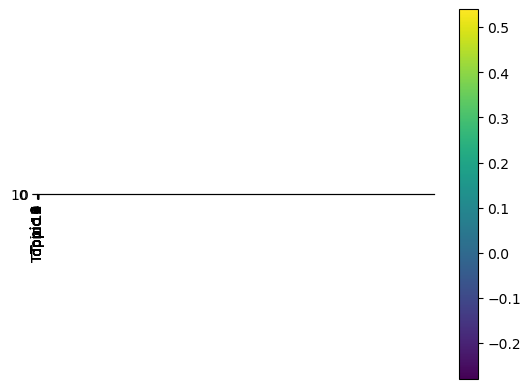

In [62]:
# визуализация модели LSA, к сожалению, через pyLDAvis невозможно вывести модель LSA
plt.imshow(lsa_model.components_, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(15), ['Topic ' + str(i) for i in range(15)], rotation=90)
plt.show()

1 - Архитекутра компьютера

2 - Технологии медицины

3 - GameDev

4 - Бизнес решение

5 - Интернет и связь

6 - 

7 - Беспилотники

8 -

9 - Языки программирования

10 - Сервера и ПО

11 - Блогинг

12 - Архитекутра компьютера

13 - СУБД

14 - Машинное обучение

15 - Электроника

сми

In [64]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 0, 'keyword'])

7     ошибка, команда, мочь, проблема, файл, проверя...
21    класс, объект, десериализация, поле, значение,...
24    качество, звук, пакет, звонок, сигнал, мочь, р...
27    приложение, клиент, вк, версия, писать, старый...
28    приложение, станция, язык, поиск, программа, в...
44    устройство, преобразователь, кабель, производс...
47    метрика, приложение, мониторинг, сбор, собират...
48    мониторинг, метрика, система, мочь, запрос, по...
50    система, операционный, устройство, компьютер, ...
52    коммутатор, выделять, инсталляция, клиент, сер...
55    данные, база, инстанс, мочь, ресурс, использов...
56    частота, устройство, точка, доступ, работать, ...
59    код, проект, файл, работать, весь, вс, просто,...
67    диск, данные, система, файловый, профиль, испо...
78    система, метрика, мониторинг, приложение, данн...
Name: keyword, dtype: object


In [65]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 1, 'keyword'])

41    год, видео, вс, человек, весь, индустрия, брау...
80    игра, играть, персонаж, весь, мочь, каждый, го...
81    грейс, хоппер, год, е, первый, компьютер, рабо...
83    игра, клиент, геймификация, игровой, приложени...
Name: keyword, dtype: object


In [66]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 2, 'keyword'])

17    лидар, мочь, объект, автомобиль, система, бесп...
68    ряд, средний, временный, данные, мочь, метод, ...
Name: keyword, dtype: object


In [67]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 3, 'keyword'])

87    сеть, доступность, мониторинг, время, мочь, се...
Name: keyword, dtype: object


In [68]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 4, 'keyword'])

0     алгоритм, информация, стеганография, контент, ...
1     ребенок, геркон, игрушка, мочь, простой, конта...
2     млн, продажа, год, квартал, пк, рынок, динамик...
4     человек, год, вид, становиться, хуманизация, б...
5     левин, игра, элизабет, студия, кен, человек, г...
6     система, плата, гб, порт, разъем, озу, процесс...
9     анимация, элемент, использовать, создавать, ко...
10    имя, пространство, связь, анонимный, функция, ...
11    движение, фаблаб, проект, делать, робот, мейке...
12    тест, кейс, регрессионный, история, спринт, те...
13    сварка, ультразвуковой, материал, наконечник, ...
15    язык, использовать, отдел, платформенный, проб...
18    окрестность, правило, клетка, сосед, радиус, п...
19    класс, код, процессор, аннотация, создавать, и...
20    облачный, мочь, виртуальный, использовать, раб...
22    кластер, безопасность, доступ, пользователь, з...
23    педаль, схема, батарейка, усилитель, транзисто...
29    баня, щит, умный, банщик, управление, весь

In [69]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 5, 'keyword'])

64    парсер, функция, входной, использовать, данные...
Name: keyword, dtype: object


In [70]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 6, 'keyword'])

79    работа, анимация, ролик, весь, самый, заказчик...
Name: keyword, dtype: object


In [71]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 7, 'keyword'])

3    дыра, чрной, событие, вселенная, горизонт, мат...
Name: keyword, dtype: object


In [72]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 8, 'keyword'])

36    пакет, функция, субд, команда, переменный, схе...
Name: keyword, dtype: object


In [73]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 9, 'keyword'])

14    файл, конфигурационный, интерфейс, сетевой, на...
Name: keyword, dtype: object


In [74]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 10, 'keyword'])

26    сигнал, схема, элемент, триггер, вход, логичес...
Name: keyword, dtype: object


In [75]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 11, 'keyword'])

8    реактивный, стрим, оператор, поток, элемент, с...
Name: keyword, dtype: object


In [76]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 12, 'keyword'])

16    балл, статья, сумма, номинация, технический, к...
Name: keyword, dtype: object


In [77]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 13, 'keyword'])

25    данные, метрика, система, блок, весь, запрос, ...
Name: keyword, dtype: object


In [78]:
print(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 14, 'keyword'])

58    год, сертификат, обучение, курсы, работа, спец...
Name: keyword, dtype: object


In [79]:
dfHabr1.head()

,TitleCompany,Description,Reiting,Categories,TextPostLemat,TextPostToken,bigram,trigram,keyword,clustersAgglomerative,clustersKmeans,clustersSpectral
0,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",общий обзор новый алгоритм стеганография позво...,"[общий, обзор, новый, алгоритм, стеганография,...","[(общий, обзор), (обзор, новый), (новый, алгор...","[(общий, обзор, новый), (обзор, новый, алгорит...","алгоритм, информация, стеганография, контент, ...",4,4,1
1,Timeweb Cloud,Облачная платформа для разработчиков и бизнеса,1542.55,"DIY или Сделай сам, История IT",студенческий год родитель союз студент часто п...,"[студенческий, год, родитель, союз, студент, ч...","[(студенческий, год), (год, родитель), (родите...","[(студенческий, год, родитель), (год, родитель...","ребенок, геркон, игрушка, мочь, простой, конта...",4,4,8
2,Selectel,IT-инфраструктура для бизнеса,1935.27,"IT-компании, Производство и разработка электро...",явление называть именно обвал дело продажа жес...,"[явление, называть, именно, обвал, дело, прода...","[(явление, называть), (называть, именно), (име...","[(явление, называть, именно), (называть, именн...","млн, продажа, год, квартал, пк, рынок, динамик...",4,4,1
3,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",закон физика говорить обо весь возможный явлен...,"[закон, физика, говорить, обо, весь, возможный...","[(закон, физика), (физика, говорить), (говорит...","[(закон, физика, говорить), (физика, говорить,...","дыра, чрной, событие, вселенная, горизонт, мат...",7,4,1
4,RUVDS.com,VDS/VPS-хостинг. Скидка 15% по коду HABR15,2393.91,"Электроника для начинающих, Системное админист...",существовать нарисовать вид анимешной девушка ...,"[существовать, нарисовать, вид, анимешной, дев...","[(существовать, нарисовать), (нарисовать, вид)...","[(существовать, нарисовать, вид), (нарисовать,...","человек, год, вид, становиться, хуманизация, б...",4,4,2


In [80]:
df = ['данные, метод, система, изменение, цепочка, вакансия, сотрудник, диск, создание, канал',
'игра, человек, работа, дать, файл, статья, сообщение, создать, конфигурация, настройка',
'файл, система, проект, пакет, приложение, мочь, мониторинг, проблема, программа, библиотека',
'схема, значение, компания, запрос, код, сигнал, переменный, инстанс, кнопка, кнопка текст',
'функция, данные, время, использовать, пример, игра, ресурс, база, клиент, компьютер',
'устройство, время, год, работать, уровень, пользователь, питание, пк, рабочий, плата',
'использовать, язык, мочь, данные, разработчик, год, работать, играть, поиск программа, приложение станция',
'мочь, кластер, коммутатор, приложение, каждый, команда, уровень, инфраструктура, следующий, канал',
'год, система, стать, изображение, обучение, ресурс, человек, безопасность, инфраструктура, результат',
'сервер, функция, часть, переменный, замыкание, приложение, класс, клиент, пользователь, тест',
'код, год, процессор, использовать, обучение, доступ, класс, ия, безопасность, название',
'год, поле, делать, класс, хабра, пользователь, автор, технический, первый, каждый',
'использовать, новый, работать, пользователь, сеть, событие, интерфейс, тест, адрес, команда',
'работа, устройство, система, объект, значение библиотека сериализатор, десериализация, сериализация результат использование, сериализация результат, сериализация, сериализатор сериализация результат',
'запрос, метрика, система, например, сша, пк, ресурс, слот, снимок, порт система']

In [81]:
dfCosinTest = pd.DataFrame({'texts': df})

In [82]:
find_nearest_to = str(dfHabr1.loc[dfHabr1['clustersAgglomerative'] == 15, 'keyword'])

In [83]:
# формирование весов tf-idf
tfidf = TfidfVectorizer()
mx_tf = tfidf.fit_transform(df)
new_entry = tfidf.transform([find_nearest_to])

In [84]:
type(mx_tf)

scipy.sparse._csr.csr_matrix

In [85]:
sdf = pd.DataFrame.sparse.from_spmatrix(mx_tf)
sdf

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.33771,0.000000,0.000000,0.261695,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.33771,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.333037,...,0.000000,0.000000,0.000000,0.289187,0.000000,0.000000,0.00000,0.000000,0.289187,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.311519,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.311519,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.360132,0.000000,0.000000,0.00000,0.312714,0.000000,0.279070,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.312714,0.000000,0.00000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.316570,0.234509,0.000000,0.000000,...,0.000000,0.316570,0.316570,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.214939,0.258936,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.334149
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.309646,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.323653,0.000000,0.00000,0.000000,0.239756,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.323653,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.314907,0.000000,0.00000,0.362658,0.000000,0.000000


In [86]:
cosine_similarity(mx_tf)

array([[1.        , 0.        , 0.05012935, 0.        , 0.07303129,
        0.        , 0.06776233, 0.09080196, 0.05208198, 0.        ,
        0.        , 0.        , 0.        , 0.02424497, 0.08943761],
       [0.        , 1.        , 0.09008711, 0.        , 0.09043272,
        0.        , 0.        , 0.        , 0.09359617, 0.        ,
        0.        , 0.        , 0.        , 0.04357047, 0.        ],
       [0.05012935, 0.09008711, 1.        , 0.        , 0.        ,
        0.        , 0.22152497, 0.13994754, 0.05532766, 0.06419857,
        0.        , 0.        , 0.        , 0.07269095, 0.09501124],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.07888394,
        0.07803503, 0.        , 0.        , 0.0377415 , 0.06961259],
       [0.07303129, 0.09043272, 0.        , 0.        , 1.        ,
        0.09899591, 0.13164018, 0.        , 0.08060448, 0.19695175,
        0.06375134, 0.        , 0.06245583, 

In [87]:
new_entry = tfidf.transform([find_nearest_to])
pd.DataFrame.sparse.from_spmatrix(new_entry)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [88]:
cosine_similarities = cosine_similarity(new_entry, mx_tf).flatten()
cosine_similarities

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [89]:
# запишем все попарные результаты сравнений
dfCosinTest['cos_similarities'] = cosine_similarities
# и отсортируем по убыванию (т.к. cos(0)=1)
dfCosinTest = dfCosinTest.sort_values(by=['cos_similarities'], ascending=[0])
dfCosinTest

,texts,cos_similarities
0,"данные, метод, система, изменение, цепочка, ва...",0.0
1,"игра, человек, работа, дать, файл, статья, соо...",0.0
2,"файл, система, проект, пакет, приложение, мочь...",0.0
3,"схема, значение, компания, запрос, код, сигнал...",0.0
4,"функция, данные, время, использовать, пример, ...",0.0
5,"устройство, время, год, работать, уровень, пол...",0.0
6,"использовать, язык, мочь, данные, разработчик,...",0.0
7,"мочь, кластер, коммутатор, приложение, каждый,...",0.0
8,"год, система, стать, изображение, обучение, ре...",0.0
9,"сервер, функция, часть, переменный, замыкание,...",0.0


0 = 14

1 = 15

2 = 6

3 = 2

4 = 3

5 = 5

6 = 4

7 = 8

8 = 1

9 = 13

10 = 7

11 = 9

12 = 10

13 = 11

14 = 12

### 2.4 Разведочный анализ

### Вывод

In [90]:
X = dfHabr1['keyword']
y = dfHabr1['clustersAgglomerative']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [92]:
my_tags = dfHabr1['clustersKmeans'].unique()
my_tags

array([ 4, 12,  7,  0, 11, 13,  2,  6,  1, 10, 14,  9,  5,  8,  3],
      dtype=int64)

In [95]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [96]:
%%time
nb.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 4.57 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [97]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: total: 0 ns
Wall time: 1.01 ms


In [98]:
y_pred[0]

4

In [99]:
print(X_test[0], y_test[0], y_pred[0])

алгоритм, информация, стеганография, контент, новый, метод, чувствительный, мочь, безопасный, использование 4 4


In [100]:
my_tags

array([ 4, 12,  7,  0, 11, 13,  2,  6,  1, 10, 14,  9,  5,  8,  3],
      dtype=int64)

In [101]:
from sklearn.metrics import accuracy_score

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.75
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         1
           4       0.75      1.00      0.86        21
           5       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.75        28
   macro avg       0.15      0.20      0.17        28
weighted avg       0.56      0.75      0.64        28



C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

In [103]:
%%time
sgd.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 2.92 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [104]:
%%time
y_pred = sgd.predict(X_test)

CPU times: total: 0 ns
Wall time: 561 µs


In [105]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6428571428571429
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           2       0.00      0.00      0.00         1
           4       0.74      0.81      0.77        21
           5       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0

    accuracy                           0.64        28
   macro avg       0.15      0.15      0.15        28
weighted avg       0.60      0.64      0.62        28



C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_cla

In [106]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])

In [107]:
%%time
logreg.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 16.5 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [108]:
%%time
y_pred = logreg.predict(X_test)

CPU times: total: 0 ns
Wall time: 1 ms


In [109]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7142857142857143
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           2       0.00      0.00      0.00         1
           4       0.76      0.90      0.83        21
           5       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1

    accuracy                           0.71        28
   macro avg       0.22      0.23      0.22        28
weighted avg       0.62      0.71      0.66        28



C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\essww\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [110]:
econ_text = 'время неумолимо бежать вперед выходить новый гаджет постепенно заменять старый превращать тыква хороший случай тапочек звонок смартфон становиться практически одинаковый дисплей весь площадь передний панель полный отсутствие аппаратный кнопка беспроводной зарядка это здорово хотеться взять рука старый необычный наш время qwerty смартфон попытаться использовать основной цена мочь приятно удивлять бу девайс купить несколько сотня рубль проблема клиент приложение версия android безбожно устаревать давно работать желание воскрешать старый девайс превыше потребительский качество приходить мысль почему написать ноль свой клиент популярный приложение вк музыка youtube трекинг посылка садиться писать необходимый повседневный жизнь приложение ноль голый api android либо фреймворков appcompat получаться это узнавать статья мотивация самый дело копаться старый девайса пытаться находить применение это очень интересный затягивать дело зачастую попытка оживлять девайс заключаться прочтение большой количество мануал документация копание терминал компиляция загрузчик ядро подобный занятие интересный весь уровень хардварный системный прикладной пользовательский предыдущий статья моддиль девайса весь уровень ремонтировать железный болячка написать несколько статья системный моддинг компиляция загрузчик неизвестный китайский устройство узнавать пользовательский опыт установка готовый кастомный прошивка летний устройство сегодняшний день обходить прикладной уровень моддинг устройство т е написание самый обычный повседневный программа который сложно представлять жизнь современный человек время выход первый galaxy s год многие сутки красноглазить java версия аська сидеть вконтакте большинство заглядывать смартфон каждый пара минута проверка нотификация год смартфонный жизнь становиться похожий который привыкать соц сеть мессенджер пушить потоковый видео многие успевать привязываться жизнь конкретно самый девайса год давно миновать тенденция разработка приложение кардинальный поменяться учитывать многий читатель любить выбрасывать девайса мусорка правильно делать наверняка регулярно заглядывать полочка свой пыльный бывший гаджет рассматривать теплота сожаление понимать время проходить проходить посмотреть навык огромный мотивация программер мочь многое число запиливать весь самый необходимый приложение давно лелеять идея подумывать реализовать весь свой жизнь писать c практически щупать api android ui фрейморк день очень сильно зачесываться рука написать эдакий причем сразу весьма серьезный весь устройство год самый молодой являться реплика lumia который успевать замоддить рождаться идея написать клиент youtube вк трекинг придача б выделять неделя время должный успевать заканчивать пусть сыроватый вполне юзабельный клиент любить сервис начинать думать планирование написание приложение старый мобильный ос любой платформа требовать планирование работать учет ограничение целевой платформа сразу несколько ограничение раззадоривать пыл большинство свой старый версия android работать одноядерный чипсет значит лимитировать многопоточность никакой работа ui поток кроме обновление интерфейс поскольку первый версия система интерфейс менее отзывчивый свежий нужно сохранять баланс функционал симпатичность скорость работа приложение должный оптимально работать следующий условие мб озу который свободно средний мб сбер привет вылет гб озу ядро мгц видео ядро уровень mali malii негусто сходить второй ограничение становиться тотальный устаревание корневой сертификат многие знать просто мобильный система обновлять поэтому приходиться идти хаки делать сервер реле который преобразовывать трафик https http просто отключать проверка верификация ssl это кейс api vk решать отдельный сервер реле который отправлять запрос сервер вк обратно возвращать обычный результат json третий ограничение становиться android targetsdk android cupcake никакой appcompat кушать драгоценный свободный место никакой сервис google год чистый api система условие год назад писаться первый приложение android раздобывать лепешка расшибаться портировать свой приложение гордость сказать приложение работать android устройство полный энтузиазм садиться писать код основной часть статья решать поделить каждый приложение отдельно конкретный объяснение делать хотеться заранее сказать особо давно писать android зато писать winforms поэтому решение мочь показываться странный некоторый решение обусловливать версия android например нотификация первый версия android notification builder notification похожий структура приложение писать java вконтакте первый дело начинать писать клиент вк сразу определяться свой хотелок который весьма скромный возможность листать диалог читать сообщение отправлять полный поддержка qwerty клавиатура т е отправка enter плюс возможность слушать музыка ограничение вк бочка кой случай гнать просто публичный api ограничение хотя здорово снова хотеться почувствовать эмоция который ощущать прослушивание музыка школяр свой первый android смартфон год прилетать школа слушать плейлист практически девайса идентичный железо версия android помнить пользоваться прелесть многозадачность android g интернет g чипсет просто поддерживать песня слушать поставлять второй качаться пока песня доигрывать второй скачаться итак хотелка выбирать пора начинать писать приложение дебаг устройство galaxy s android jb китайский galaxy s mini i android фото высоко samsung galaxy s i android эмулятор kitkat android studio уметь проблема собирать приложение вплоть версия android последний build tools target sdk главное выкидывать appcompat androidx юнит тест build gradle либо проблема цеплять устройство adb отладчик проблема работать первый дело начинать писать активитя полноэкранный форма терминология android экран приложение диалог должный секунда подгружать данные строить морда весь суть весь код клиент получение ответ api вк разбор json датасет визуализация датасет экран это вводить объект vk который делать асинхронный запрос сервер оборачивать работа сервер реле парсить json vkobjectprocessor это скоро отрефакториться vkdataset поздно архитектура приложение получаться довольно простой примитивный старт активитя авторизация проверять данный приложение persiststorage наличие api токен отсутствие запрашивать авторизация это становиться классический среди различный самопальный клиент клиент прикидываться официальный приложение вк это использоваться связка app id app secret приложение вконтакте android авторизация приложение перенаправлять страница диалог поскольку пуша лонгполлинг метод обновление оставаться заданный интервал это handler который сечь брать список диалог сервер проверять обновляться данные обновлять датасет отправлять сигнал обновление интерфейс который построить listview кроме кеш аватарка точно распаралелленый несколько поток загружать данный момент превьюшка храниться хэшмап это сообщение реализовать схожий образ данный момент возможность горячий подгрузка сообщение сверху поэтому обновляться последний сообщение скоп сразу шустро весь это работать вполне неплохо основной процессорный время уходить разбор тяжелый json отчасти вино вк мало кастрировать функционал gethistory последний версия api возможность возвращать поле который нужный поступать аудиозапись музыка api настоящий заноза разработчик клиент который приходиться подолбаться правда недолго основной запрос сервер реле почему сделать музыка суть обход простой сгенерировать специальный api токен свободно обращаться метод связывать музыка необходимость притворяться официальный клиент подписывать запрос md ключ примитивный php скрипт предоставлять возможность позволять получать доступ база музыка вк однако ограничение типичный пользователь должный открытый аудиозапись php audiorelay for minivk c monobogdan token censored function vkrequest request global token curl curl init https api vk com method request access token token v curl setopt curl curlopt returntransfer true return curl exec curl function audioget uid get uid return vkrequest audio get owner id uid count function audiosearch query get query return vkrequest audio search q query count function audiogetdetails id get id return vkrequest audio getbyid audios id function audiostream url get url curl curl init urldecode url curl setopt curl curlopt returntransfer true return curl exec curl actions array actions get audioget actions search audiosearch actions getdetails audiogetdetails actions stream audiostream if isset get act act get act if isset actions act exit actions act exit internal error итог получаться рабочий плеер поиск музыка добавлять трек производительность оставаться отличный ссориться ребята вк хотеть поэтому добавлять возможность качать трек пока становиться стоить дружелюбный разработчик кастомный клиент получать итог довольно простенький клиент вк который практически потреблять озу шустро работать хватать куча различный фич минимум прсомотр лента стена успеться проект интересный продолжать наращивать фишечка потихоньку близко релиз слегка причесывать клиент добавлять вкшный дизайн приделывать анимированный боковой меню animation помнить youtube разработка клиент youtube свой особенность первый отличие клиент вк видео реле просто загружать слишком трафик второй youtube отдавать видео формат который поддерживать старый устройство основной это h p сожаление потоковый видео софтовый декодирование укладывать лопатка большинство одноядерник год ситуация осложняться videoview стандартный плеер весь смартфон который отлаживать приложение уметь игнорировать ошибка ssl просто валиться ошибка приходиться придумывать видосик хотеться смотреть крутой amoled дисплей galaxy s посидеть подумать придумывать поиск база youtube получение информация прямой ссылка видео решать использовать альтернативный фронтэнд youtube который называться invidous api крутой штука свой api который распределять пул токен ютуб отдавать ответ вид json формат запрос очень простой url инстанс invidous api v метод например search q test region ru hl ru выдавать результат поиск test российский регион очень удобно invidous отдельный сервис целый сеть т н инстанс хотеть юзай поскольку большинство инстанс прятаться свежий сертификат приходиться идти довольно известный костыль отключение верификация хостнейм httpurlconnection public static void disablesslcertificatechecking trustmanager trustallcerts new trustmanager new x trustmanager public x certificate getacceptedissuers return null override public void checkclienttrusted x certificate arg string arg throws certificateexception not implemented override public void checkservertrusted x certificate arg string arg throws certificateexception not implemented try sslcontext sc sslcontext getinstance tls sc init null trustallcerts new java security securerandom httpsurlconnection setdefaultsslsocketfactory sc getsocketfactory httpsurlconnection setdefaulthostnameverifier new hostnameverifier override public boolean verify string hostname sslsession session return true catch keymanagementexception e e printstacktrace catch nosuchalgorithmexception e e printstacktrace поскольку возможность воспроизводить потоковый видео онлайн решать просто предварительно загружать собственный менеджер закачка возможность последующий очистка кеш поскольку устройство p качество нужный выбирать p p mp avc кодек среднее ролик минута весить около мегабайт hsdpa загрузка подобный видео занимать около минута подождать закинуть тестовый версия беседа любитель ретро мобилка человек восторг поскольку invidous отчасти строиться анонимность авторизация однако свой задача посмотреть видосик выполнять нормально поэтому весь ui приложение поделить вкладка тренд популярный история поиск подписка история реализовывать сторона клиент некоторые подход показываться плюс однако минимальный задел клиент мочь смотреть видео скачать приложение бэкэнд полностью открытый исходный код доступный лицензия gplv следить статус проект github последний версия скачать релиз проект текущий хотеться портировать android несмотря приложение целое иметь targetsdk оно работать отказываться android слегка поменяться бинарный формат xml разметка приложение старый система вылетать исключение это решать eclipse adt зуб импортировать проект вперед кроме экспериментировать попытка сильно уменьшать нагрузка сеть процессор путем облегчение датасет json вк весить среднее кб который ядерный чипсет частота мгц мочь долго жевать негативно сказываться ui примитивный keyvalue формат который содержать нужный поле умещаться кб текстовый вид благодаря свой примитивность весь парсинг substring indexof поиск ключ хешмап налегать процессор благодаря наработка запиливать примитивный клиент вкшечка j me целое сделать единый формат датасет мессенджер бэкэнд реализовывать угодно telegram вк личный сообщение хабер платформа делать морда заводить современный мессенджер sailfish j me symbian winmobile практически пот кровь полный адаптация кнопочный управление клиент проблема писать сообщение любой клавиатура число qwerty однако основной интерфейс полностью адаптировать кнопка требовать выполнение некоторый действие палец заключение получаться вполне неплохо приложение кой сыроватый явно дотягивать функционал большой версия кое таки выигрывать легкий быстрый самый главное мочь продлять жизнь любимый девайса считать это классно средний потребление озу оба клиент мб вес apk кб момент выход статья значить писать голый api модный фреймворков остальной функционал кой android продолжать неплохо работать наш время например dlna стриминг дом e mail клиент банкинг смска уверенный это покрывать потребность большинство пользователь это называть старый смартфон бесполезный писать статья цель показывать старый девайса отнюдь тыква щепотка энтузиазм глаз любовь гаджет заодно поделиться свой приложение часто комментарий писать хотеть пользоваться свой смартфон далеко устаревать версия android считать ждать ваш мнение комментарий зарегистрировать пользователь мочь участвовать опрос входить пожалуйста старенький девайс появляться второй жизнь определенно запланировать устаревание продолжать жить неюзабельный вокруг прыгать проголосовать пользователь воздерживаться пользователь зарегистрировать пользователь мочь участвовать опрос входить пожалуйста полезно развивать приложение старый система развивать это нужный пустой трата время делать модный приложенька флаттер проголосовать пользователь воздерживаться пользователь  \n'

In [111]:
econ_text = remove_multiple_spaces(remove_numbers(remove_punctuation(econ_text.lower())))


NameError: name 'remove_multiple_spaces' is not defined

In [112]:
%%time
econ_text = lemmatize(econ_text)

NameError: name 'lemmatize' is not defined

In [113]:
ect_pred = nb.predict([econ_text])
ect_pred

array([4], dtype=int64)